# Portrait Diffusion

Stable Diffusion in Colab using HuggingFace `diffusers` with built in prompts for high quality portrait images of magical characters.

*Requirements*
- HuggingFace account (create free [here](https://))

<br>

---

<br>

## Install dependencies


In [ ]:
!pip install numpy matplotlib pillow --quiet
!pip install torch transformers diffusers --quiet
!pip install ftfy ipywidgets --quiet

     |████████████████████████████████| 4.9 MB 10.5 MB/s 
     |████████████████████████████████| 153 kB 53.9 MB/s 
     |████████████████████████████████| 163 kB 58.7 MB/s 
     |████████████████████████████████| 6.6 MB 44.5 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 1.6 MB 34.3 MB/s 
     |████████████████████████████████| 172 kB 28.1 MB/s 
     |████████████████████████████████| 59 kB 7.7 MB/s 
     |████████████████████████████████| 6.0 MB 61.4 MB/s 
     |████████████████████████████████| 190 kB 72.7 MB/s 
     |████████████████████████████████| 177 kB 77.6 MB/s 
     |████████████████████████████████| 52 kB 944 kB/s 


## Import dependencies

In [ ]:
# import libs
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline

from huggingface_hub import notebook_login

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from pathlib import Path

## Check GPU status

If you get the following message after running the below cell:
```
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.
```
Then GPU is not currently connected to runtime. Fix this by going to `Edit > Notebook Settings > Hardware Accelerator` and select `GPU`. Then, re-run the below cell.

Otherwise, everything is OK and you can proceed.

In [ ]:
!nvidia-smi

Fri Sep 30 04:51:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Authenticate with HuggingFace
Enter your token below to load the weights from HuggingFace

In [ ]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


## Download the model weights and then load them onto the GPU

In [ ]:
# load model
model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"
pipe = StableDiffusionPipeline.from_pretrained(model_id, use_auth_token=True)
pipe = pipe.to(device)

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

{'trained_betas'} was not found in config. Values will be initialized to default values.


In [ ]:
#@title Set the parameters and prompt for diffusion

# set params 
# use resolution close to 512x512
width = 512
height = int(width * 5 / 4)
# 50 or 100 
num_steps = 100
# 7.5 or 12 or 15
scale = 12 #@param

# set the character description
character = "mythical nymph with black hair and golden ornate crown" #@param {type:"string"}

### OTHER character descriptions to try
# Green pink bling bling of the queen of forest, complicated vines branches and bling bling flowers in naturalism headwears
# High elf wearing high fashion made of wood and leaves
# 3d close-up profile portrait wearing a intricately detailed autumn mask, fall leaves, thistles, phoenix, dried plants, foxes, wind, creature
# elf, rose thorn crown, thorns everywhere, headshot
# a person with blue eyes and green hair
# of a mythical nymph, deep red hair, shiny flowing red wings,

# RECOMMENDED: DO NOT MODIFY STYLE OR QUALITY MODIFIERS
prompt_styles = {
    "A": "fashion photoshoot, hyperrealistic, intricate details, shiny",
    "B": "dark fantasy, intricate, elegant, highly detailed, digital painting, artstation, highly saturated colors, concept art, matte, 3 d 8 k octane rendered, sharp focus, illustration, art by artgerm and alphonse mucha, leesha hannigan",
    "C": "by alexander mcqueen and iris van herpen, hyperrealistic masterpiece painted by jaime jones, jana schirmer, artgerm and alphonse mucha",
    "D": "4k, rule of thirds, extreme detail, detailed drawing, trending artstation, hd, fantasy, d&d, realistic lighting, by alphonse mucha, greg rutkowski, sharp focus, backlit, bright red hair, elegant",
    "E": "a photorealistic painting by Wendy Froud, featured on cgsociety, fantasy art, daz3d, photorealistic, behance hd",
    "F": "depth of field, zeiss lens, detailed, symmetrical, centered, fashion photoshoot, by annie leibovitz and steve mccurry, david lazar, jimmy nelsson, breathtaking, 8k resolution, extremely detailed, beautiful, establishing shot, artistic, hyperrealistic, beautiful face, octane render",
    "G": "a photorealistic portrait painting by Anna Dittmann, symmetrical body, hyperrealistic, intricate details, cinematic lighting, 4k, 8k, trending on cg society, gothic art, daz3d, pre-raphaelite, grotesque"
}
# trending on cg society, gothic art, daz3d, pre-raphaelite, grotesque

style = "D" #@param ["A", "B", "C", "D", "E", "F", "G"]

prompt = "Portrait of {}, {}".format(character, prompt_styles[style])

prompt

'Portrait of mythical nymph with black hair and golden ornate crown, 4k, rule of thirds, extreme detail, detailed drawing, trending artstation, hd, fantasy, d&d, realistic lighting, by alphonse mucha, greg rutkowski, sharp focus, backlit, bright red hair, elegant'

  0%|          | 0/101 [00:00<?, ?it/s]

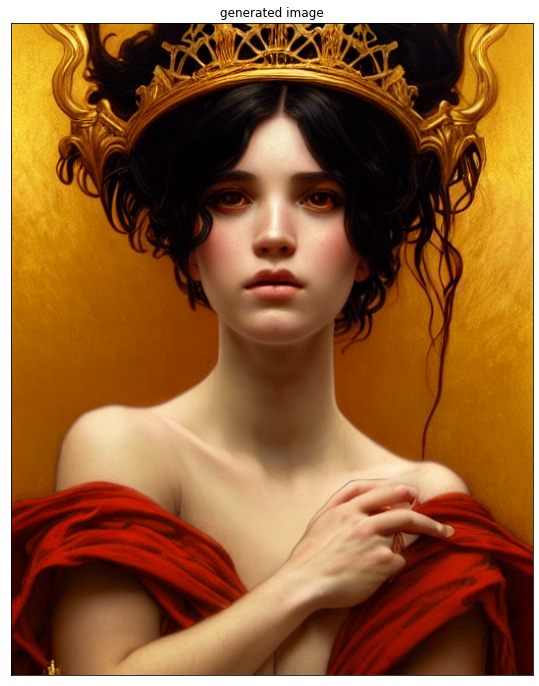

In [ ]:
# diffuse and show results (1 samples)
# do not change in colab (Colab will only let us do 1 sample)
num_samples = 1 

with autocast("cuda"):
    out_dict = pipe([prompt] * num_samples, 
                    width=width, 
                    height=height, 
                    guidance_scale=scale,
                    num_inference_steps=num_steps)
    
images_out = out_dict["sample"]

grid_length = np.ceil(np.sqrt(len(images_out)))

if grid_length > 1:
    fig, axes = plt.subplots(grid_length, grid_length, figsize=(16,16))
    for idx, (im, ax) in enumerate(zip(images_out, axes.flatten())):
        ax.imshow(im)
        ax.set_title(idx)
        ax.set_xticks([])
        ax.set_yticks([])
    print("\t\t     generated images")
else:
    plt.figure(figsize=(12,12))
    plt.imshow(images_out[0])
    plt.title("generated image")
    plt.xticks([])
    plt.yticks([])

plt.show()

## Save selected image

In [ ]:
# select image to continue with
idx_selected = 0

image_11 = images_out[idx_selected]

file_name = "my_image" # if you change this file name make sure to update it below when running GFPGAN

# Path("./images_out/").mkdir(exist_ok=True)

# image_11.save("images_out/{}.png".format(file_name))

image_11.save("{}.png".format(file_name))

---